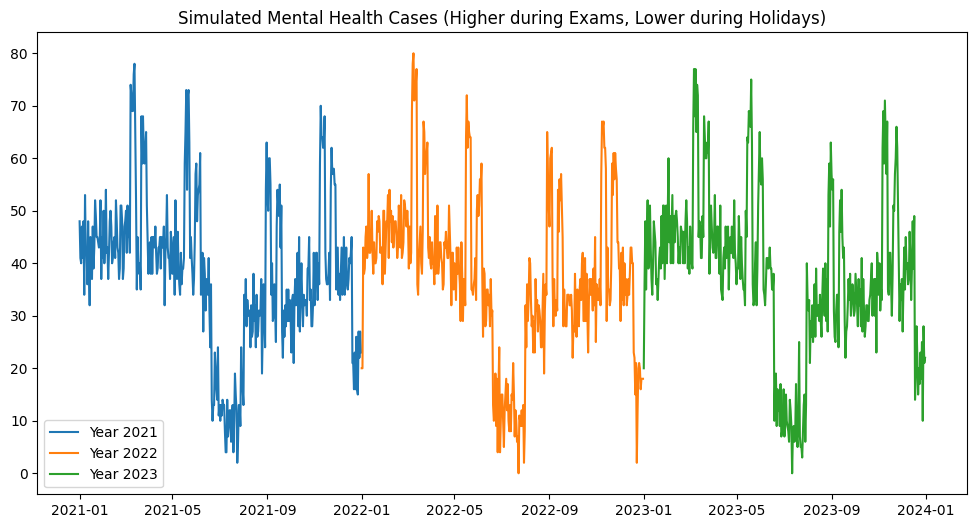

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate 3 years of daily data
dates = pd.date_range(start="2021-01-01", end="2023-12-31", freq="D")
df = pd.DataFrame({"Date": dates})
df["Year"] = df["Date"].dt.year
df["Week_No"] = df["Date"].dt.isocalendar().week

# Exam + results weeks (4 exam periods per year)
exam_weeks = [10, 20, 35, 45]
result_weeks = [12, 22, 37, 47]
holiday_weeks = list(range(25, 31)) + [51, 52]

df["Exam_Week"] = df["Week_No"].isin(exam_weeks).astype(int)
df["Results_Week"] = df["Week_No"].isin(result_weeks).astype(int)
df["Holiday"] = df["Week_No"].isin(holiday_weeks).astype(int)

# Base PHQ-9 & GAD-7 scores
np.random.seed(42)
df["Avg_PHQ9"] = (
    5
    + 2*np.sin(2*np.pi*df["Week_No"]/52)   # yearly seasonality
    + 4*df["Exam_Week"]
    + 3*df["Results_Week"]
    - 2*df["Holiday"]
    + np.random.normal(0, 1, len(df))
)

df["Avg_GAD7"] = (
    4
    + 2*np.cos(2*np.pi*df["Week_No"]/52)
    + 3*df["Exam_Week"]
    + 2*df["Results_Week"]
    - 1.5*df["Holiday"]
    + np.random.normal(0, 1, len(df))
)

# Counselling & forum activity
df["Counselling_Bookings"] = (
    10 + 2*df["Avg_PHQ9"] + 2*df["Avg_GAD7"]
    + 25*df["Exam_Week"] + 20*df["Results_Week"]
    - 10*df["Holiday"]
).astype(int)

df["Forum_Posts"] = (
    5 + df["Avg_PHQ9"] + df["Avg_GAD7"]
    + 12*df["Exam_Week"] + 9*df["Results_Week"]
    - 6*df["Holiday"]
    + np.random.normal(0, 2, len(df))
).astype(int)

# Cases (actual mental health cases)
df["Cases"] = (
    15 + 3*df["Avg_PHQ9"] + 2*df["Avg_GAD7"]
    + 8*df["Exam_Week"] + 6*df["Results_Week"]
    - 12*df["Holiday"]
    + np.random.normal(0, 3, len(df))
).astype(int)

# Predicted_Cases only for Year 1 & 2
df["Predicted_Cases"] = np.where(
    df["Year"] < 2023,
    df["Cases"] + np.random.normal(0, 5, len(df)),
    np.nan
)

# Clean values
for col in ["Avg_PHQ9","Avg_GAD7","Counselling_Bookings","Forum_Posts","Cases","Predicted_Cases"]:
    df[col] = df[col].round(1)
    df[col] = df[col].clip(lower=0)

# Save dataset
df.to_csv("mental_health_dataset.csv", index=False)

# Plot yearly cases trend
plt.figure(figsize=(12,6))
for year in df["Year"].unique():
    subset = df[df["Year"] == year]
    plt.plot(subset["Date"], subset["Cases"], label=f"Year {year}")
plt.title("Simulated Mental Health Cases (Higher during Exams, Lower during Holidays)")
plt.legend()
plt.show()
# Save dataset to CSV in Colab
df.to_csv("mental_health_dataset.csv", index=False)

# If you want to download it to your computer
from google.colab import files
files.download("mental_health_dataset.csv")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0k8_j7mj/uzwy_s6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0k8_j7mj/xxkhqqsd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67413', 'data', 'file=/tmp/tmp0k8_j7mj/uzwy_s6t.json', 'init=/tmp/tmp0k8_j7mj/xxkhqqsd.json', 'output', 'file=/tmp/tmp0k8_j7mj/prophet_model3as4j0j6/prophet_model-20250907042059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Prophet Accuracy on Year 3 (with regressors):
MAE  : 4.18
RMSE : 5.15
MAPE : 14.16%
R²   : 0.88
📊 Prophet Model Accuracy: 85.84%


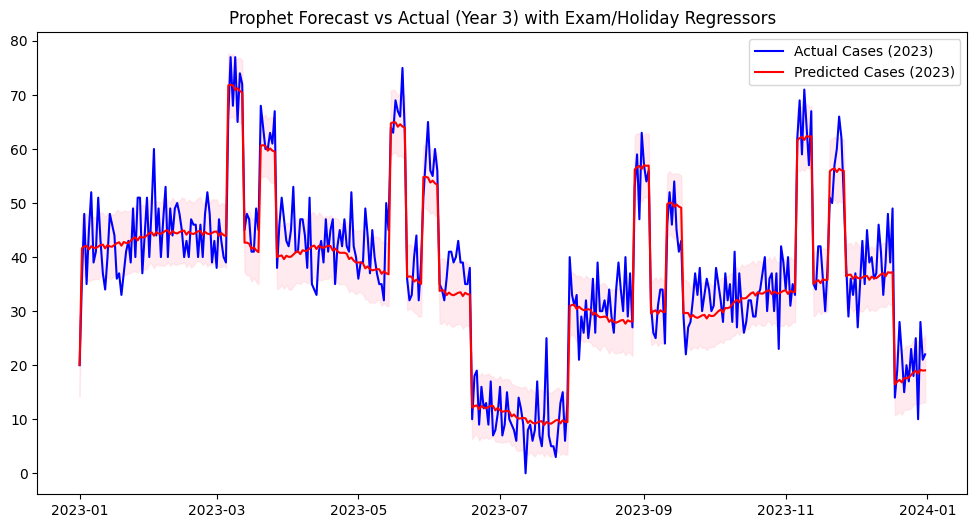

In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("mental_health_dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.rename(columns={"Date":"ds", "Cases":"y"})

# -----------------------------
# 2. Train/Test Split
# -----------------------------
train_df = df[df["ds"].dt.year < 2023]  # Year 1 & 2
test_df = df[df["ds"].dt.year == 2023]  # Year 3

# -----------------------------
# 3. Define Prophet with regressors
# -----------------------------
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_regressor("Exam_Week")
m.add_regressor("Results_Week")
m.add_regressor("Holiday")

# Fit model with regressors
m.fit(train_df[["ds","y","Exam_Week","Results_Week","Holiday"]])

# -----------------------------
# 4. Forecast for Year 3
# -----------------------------
future = test_df[["ds","Exam_Week","Results_Week","Holiday"]].copy()
forecast = m.predict(future)

# -----------------------------
# 5. Evaluate Accuracy
# -----------------------------
y_true = test_df["y"].values
y_pred = forecast["yhat"].values

# Safe MAPE (ignore zeros)
nonzero_idx = y_true != 0
mape = np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("📊 Prophet Accuracy on Year 3 (with regressors):")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.2f}")
# Calculate accuracy percentage
accuracy_percent = 100 - mape

# Print accuracy
print(f"📊 Prophet Model Accuracy: {accuracy_percent:.2f}%")


# -----------------------------
# 6. Plot Actual vs Predicted
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(test_df["ds"], y_true, label="Actual Cases (2023)", color="blue")
plt.plot(test_df["ds"], y_pred, label="Predicted Cases (2023)", color="red")
plt.fill_between(test_df["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color="pink", alpha=0.3)
plt.title("Prophet Forecast vs Actual (Year 3) with Exam/Holiday Regressors")
plt.legend()
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0k8_j7mj/_dgxvjst.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0k8_j7mj/x7e5dzqu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36252', 'data', 'file=/tmp/tmp0k8_j7mj/_dgxvjst.json', 'init=/tmp/tmp0k8_j7mj/x7e5dzqu.json', 'output', 'file=/tmp/tmp0k8_j7mj/prophet_model20sb1tsb/prophet_model-20250907042453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:24:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:24:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Prophet Accuracy on Year 3 (with regressors):
MAE  : 4.18
RMSE : 5.15
MAPE : 14.16%
R²   : 0.88
📊 Prophet Model Accuracy: 85.84%


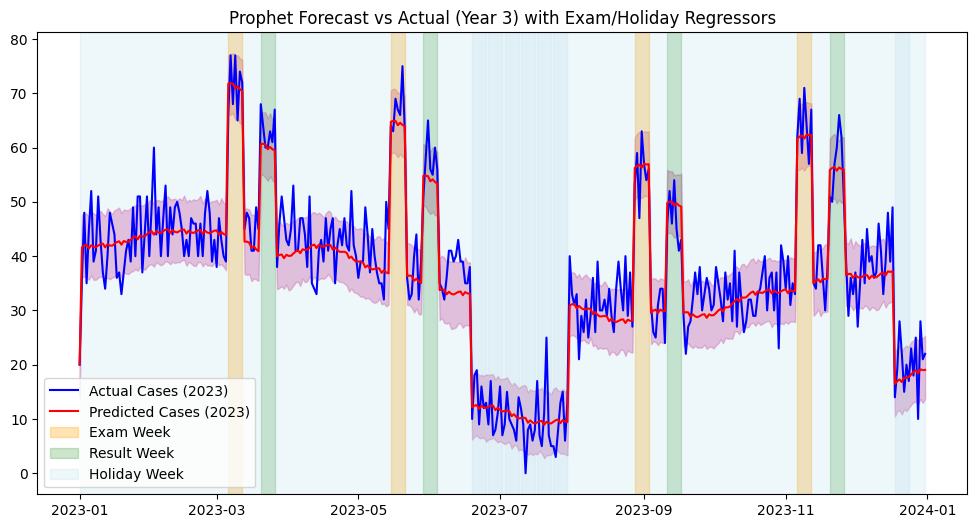

In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("mental_health_dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])
df_2023 = df[df["Date"].dt.year == 2023]
df = df.rename(columns={"Date":"ds", "Cases":"y"})


# -----------------------------
# 2. Train/Test Split
# -----------------------------
train_df = df[df["ds"].dt.year < 2023]  # Year 1 & 2
test_df = df[df["ds"].dt.year == 2023]  # Year 3

# -----------------------------
# 3. Define Prophet with regressors
# -----------------------------
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_regressor("Exam_Week")
m.add_regressor("Results_Week")
m.add_regressor("Holiday")

# Fit model with regressors
m.fit(train_df[["ds","y","Exam_Week","Results_Week","Holiday"]])

# -----------------------------
# 4. Forecast for Year 3
# -----------------------------
future = test_df[["ds","Exam_Week","Results_Week","Holiday"]].copy()
forecast = m.predict(future)

# -----------------------------
# 5. Evaluate Accuracy
# -----------------------------
y_true = test_df["y"].values
y_pred = forecast["yhat"].values

# Safe MAPE (ignore zeros)
nonzero_idx = y_true != 0
mape = np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("📊 Prophet Accuracy on Year 3 (with regressors):")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.2f}")
# Calculate accuracy percentage
accuracy_percent = 100 - mape

# Print accuracy
print(f"📊 Prophet Model Accuracy: {accuracy_percent:.2f}%")


# -----------------------------
# 6. Plot Actual vs Predicted
# -----------------------------
# Separate events
exam_weeks = [10, 20, 35, 45]
result_weeks = [12, 22, 37, 47]
holiday_weeks = list(range(25, 31)) + [51, 52]

df_2023["Week_No"] = df_2023["Date"].dt.isocalendar().week
df_2023["Exam_Week"] = df_2023["Week_No"].isin(exam_weeks)
df_2023["Result_Week"] = df_2023["Week_No"].isin(result_weeks)
df_2023["Holiday_Week"] = df_2023["Week_No"].isin(holiday_weeks)
plt.figure(figsize=(12,6))
plt.plot(test_df["ds"], y_true, label="Actual Cases (2023)", color="blue")
plt.plot(test_df["ds"], y_pred, label="Predicted Cases (2023)", color="red")
plt.fill_between(test_df["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color="#C11C84", alpha=0.3)
# Highlight Exam Weeks
for week in exam_weeks:
    plt.axvspan(df_2023[df_2023["Week_No"]==week]["Date"].min(),
                df_2023[df_2023["Week_No"]==week]["Date"].max(),
                color="orange", alpha=0.3, label="Exam Week" if week==exam_weeks[0] else "")

# Highlight Result Weeks
for week in result_weeks:
    plt.axvspan(df_2023[df_2023["Week_No"]==week]["Date"].min(),
                df_2023[df_2023["Week_No"]==week]["Date"].max(),
                color="green", alpha=0.2, label="Result Week" if week==result_weeks[0] else "")

# Highlight Holiday Weeks
for week in holiday_weeks:
    plt.axvspan(df_2023[df_2023["Week_No"]==week]["Date"].min(),
                df_2023[df_2023["Week_No"]==week]["Date"].max(),
                color="lightblue", alpha=0.2, label="Holiday Week" if week==holiday_weeks[0] else "")
plt.title("Prophet Forecast vs Actual (Year 3) with Exam/Holiday Regressors")
plt.legend()
plt.show()
